In [1]:
import pdb
from os import environ
environ['OMP_NUM_THREADS'] = '1'
#environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import sys
import argparse
from tqdm import tqdm
import arviz as az


sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

sys.path.append("../")
from utils import *
import os
import os
import shutil
import json

# tell jax to use 64bit floats
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")   


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Set up paths, read in data

In [4]:
# some info about the run
n_sets = 25
models = ['kholodenko_2000','orton_2009','shin_2014','ryu_2015','kochanczyk_2017']
display_names = ["K' 2000","O' 2009","S' 2014","R' 2015","K' 2017"]
subset_sizes=[10,20,40,60]

datadir = '../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/'
savedir = '../../../results/MAPK/mmi/Keyes_2020_data_subsample_cells/'

rng = np.random.default_rng(seed=1234)

# load the data
data_CYTO = np.load('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-CYTO_normalized.npz')
data_PM = np.load('../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-PM_normalized.npz')
    
# preprocess the data
times = {'CYTO':data_CYTO['time'], 'PM':data_PM['time']}
responses = {'CYTO':data_CYTO['data'], 'PM':data_PM['data']}

# get info about the data
ntimes = {}
ncells = {}
ntimes['CYTO'], ncells['CYTO'] = responses['CYTO'].shape
ntimes['PM'], ncells['PM'] = responses['PM'].shape

# load model info
with open('../param_est/model_info.json') as file:
    model_info = json.load(file)

# load error and uncertainty results
rel_error_full_dat = {}
RMSE_full_dat = {}
RMSE_sub_dat = {}
rel_error_sub_dat = {}
uncert95 = {}
std = {}
data_RMSE = {}
data_rel_error = {}
data_uncert95 = {}  
data_std = {}

for comp in ['CYTO', 'PM']:
    # predictive error and uncertainty
    with open(datadir + comp +'/' + 'rel_error_full_dat.json') as f:
        rel_error_full_dat[comp] = json.load(f)
    with open(datadir + comp +'/' + 'RMSE_full_dat.json') as f:
        RMSE_full_dat[comp] = json.load(f)
    with open(datadir + comp +'/' + 'RMSE_sub_dat.json') as f:
        RMSE_sub_dat[comp] = json.load(f)
    with open(datadir + comp +'/' + 'rel_error_sub_dat.json') as f:
        rel_error_sub_dat[comp] = json.load(f)
    with open(datadir + comp +'/' + 'uncert95.json') as f:
        uncert95[comp] = json.load(f)
    with open(datadir + comp +'/' + 'std.json') as f:
        std[comp] = json.load(f)

    # summary stats about the data subsets
    with open(datadir + comp +'/' + 'data_RMSE.json') as f:
        data_RMSE[comp] = json.load(f)
    with open(datadir + comp +'/' + 'data_rel_error.json') as f:
        data_rel_error[comp] = json.load(f)
    with open(datadir + comp +'/' + 'data_uncert95.json') as f:
        data_uncert95[comp] = json.load(f)
    with open(datadir + comp +'/' + 'data_std.json') as f:
        data_std[comp] = json.load(f)

# load in full data results
# load in the error data
_datadir = '../../../results/MAPK/param_est/Keyes_2020_data/'
full_dat_training_errors = json.load(open(_datadir + 'train_test_errors.json', 'r'))
full_dat_training_uncertainty = json.load(open(_datadir + 'train_test_uncertainty.json', 'r'))

#### Plots of summary stats about the subsampled data

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30369/1316929010.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['10','20','40','60'], fontsize=12)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30369/1316929010.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['10','20','40','60'], fontsize=12)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30369/1316929010.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['10','20','40','60'], fontsize=12)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_30369/1316929010.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

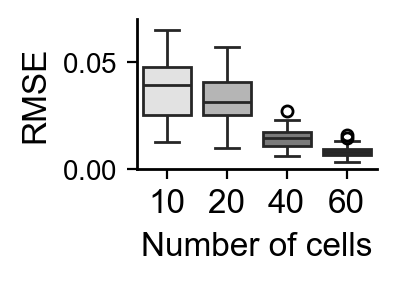

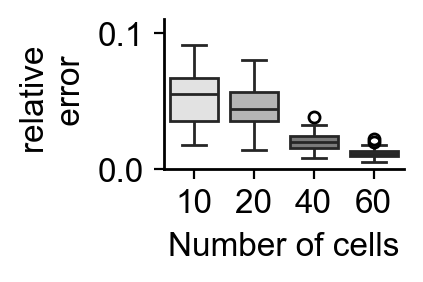

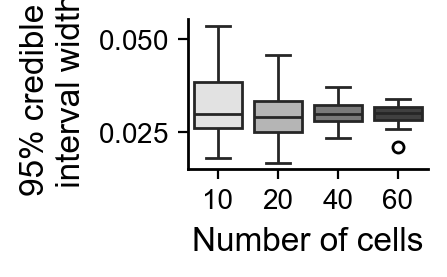

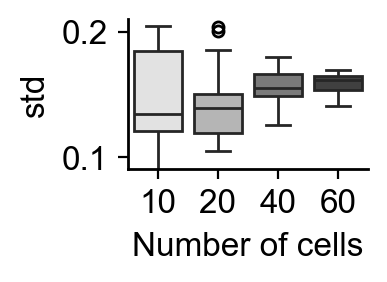

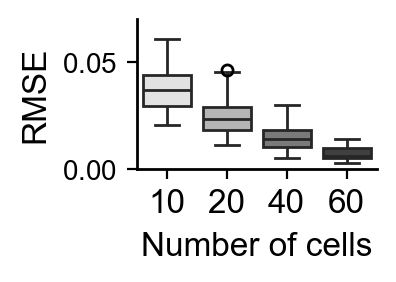

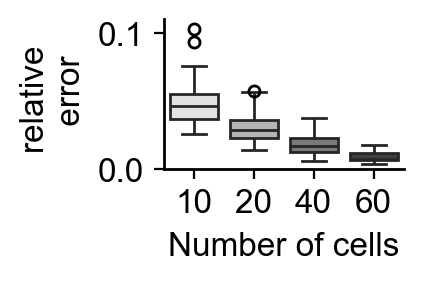

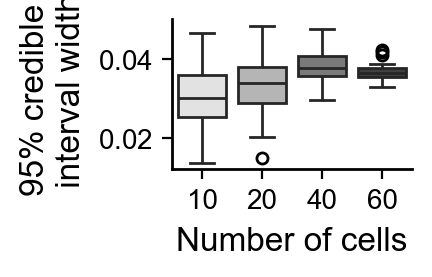

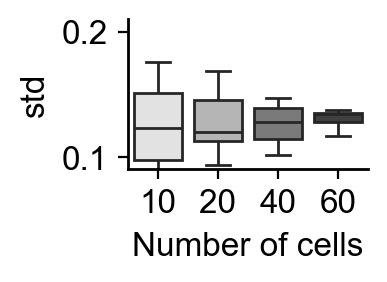

In [10]:
flierprops = dict(marker='o', markersize=4, markerfacecolor='None', markeredgecolor='black')
for comp in ['CYTO','PM']:    
    # box plot of RMSE
    width = 0.4
    data_df = pd.DataFrame(data_RMSE[comp])
    fig, ax = get_sized_fig_ax(1.2, 0.75)
    box = sns.boxplot(data_df, ax=ax, palette='Greys', flierprops=flierprops)

    ax.set_ylabel('RMSE')
    ax.set_xlabel('Number of cells')
    ax.set_xticklabels(['10','20','40','60'], fontsize=12)
    ax.set_ylim([0.0,0.07])
    # ax.set_yticks([0.2,0.8], [0.2,0.8], fontsize=12)

    fig.savefig(savedir + comp + '_data_subset_RMSE.pdf', bbox_inches='tight', transparent=True)

    # box plot of RMSE
    width = 0.4
    data_df = pd.DataFrame(data_rel_error[comp])
    fig, ax = get_sized_fig_ax(1.2, 0.75)
    box = sns.boxplot(data_df, ax=ax, palette='Greys', flierprops=flierprops)

    ax.set_ylabel('relative \n error')
    ax.set_xlabel('Number of cells')
    ax.set_xticklabels(['10','20','40','60'], fontsize=12)
    ax.set_ylim([0.0,0.11])
    ax.set_yticks([0.0,0.1], [0.0,0.1], fontsize=12)

    fig.savefig(savedir + comp + '_data_subset_rel_error.pdf', bbox_inches='tight', transparent=True)


    # box plot of uncert95
    width = 0.4
    data_df = pd.DataFrame(data_uncert95[comp])
    fig, ax = get_sized_fig_ax(1.2, 0.75)
    box = sns.boxplot(data_df, ax=ax, palette='Greys', flierprops=flierprops)

    ax.set_ylabel('95% credible \n interval width')
    ax.set_xlabel('Number of cells')

    fig.savefig(savedir + comp + '_data_subset_uncert95.pdf', bbox_inches='tight', transparent=True)

    # box plot of uncert95
    width = 0.4
    data_df = pd.DataFrame(data_std[comp])
    fig, ax = get_sized_fig_ax(1.2, 0.75)
    box = sns.boxplot(data_df, ax=ax, palette='Greys', flierprops=flierprops)

    ax.set_ylabel('std')
    ax.set_xlabel('Number of cells')
    ax.set_xticklabels(['10','20','40','60'], fontsize=12)
    ax.set_ylim([0.09,0.21])
    ax.set_yticks([0.1,0.2], [0.1,0.2], fontsize=12)

    fig.savefig(savedir + comp + '_data_subset_std.pdf', bbox_inches='tight', transparent=True)

#### Plots of the subsampled data

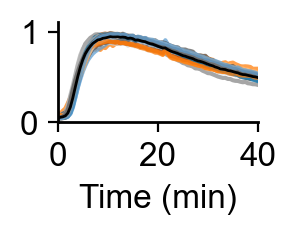

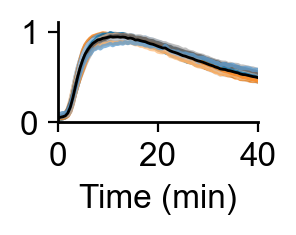

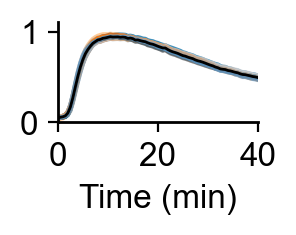

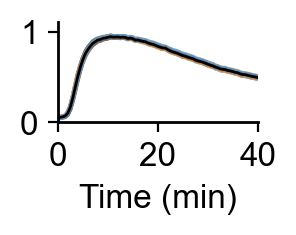

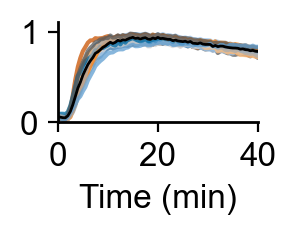

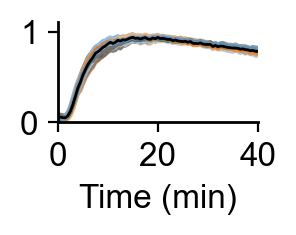

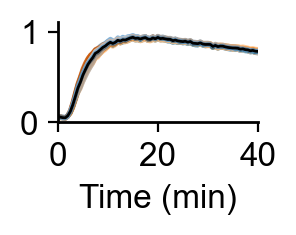

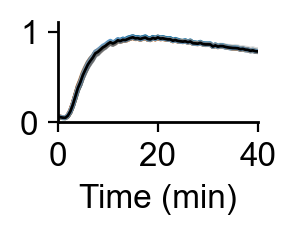

In [6]:
for comp in ['CYTO', 'PM']:    
    # this is the main loop over the subset sizes
    for size in subset_sizes:

        # create a dir for all results are this subset size
        _datadir = datadir + comp + '/subset_size_{}/'.format(size)
        
        # this is the inner loop over the number of sets st the given subset size

        fig, ax = get_sized_fig_ax(1.0, 0.5)
        for i in range(n_sets):
            # load the data
            dat = np.load(_datadir + 'sample_{}.npy'.format(i))

            ax.plot(times[comp], np.nanmean(dat, axis=1), alpha=0.75)
        ax.plot(times[comp], np.nanmean(responses[comp], axis=1), color='k', linewidth=1.0)
        
        ax.set_xlabel('Time (min)', fontsize=12)
        ax.set_xticks([0, 20, 40], [0, 20, 40], fontsize=12)
        ax.set_yticks([0, 1], [0, 1], fontsize=12)
        ax.set_xlim([0, 40])
        ax.set_ylim([0, 1.1])

        fig.savefig(savedir + comp +'_subset_size_{}_data.pdf'.format(size), bbox_inches='tight', transparent=True)

#### Build MMI predictors for each data set and compute errors

In [7]:
ELPD_loo = {'CYTO':{}, 'PM':{}}
ELPD_waic = {'CYTO':{}, 'PM':{}}
pBMA_loo_weights = {'CYTO':{}, 'PM':{}}
pBMA_waic_weights = {'CYTO':{}, 'PM':{}}
stacking_loo_weights = {'CYTO':{}, 'PM':{}}
stacking_waic_weights = {'CYTO':{}, 'PM':{}}
model_probs = {'CYTO':{}, 'PM':{}}


for comp in ['CYTO', 'PM']:    
    # this is the main loop over the subset sizes
    for size in tqdm(subset_sizes):
        print('Processing subset size {}'.format(size))

        # create a dir for all results are this subset size
        _datadir = datadir + comp + '/subset_size_{}/'.format(size)
        print(_datadir)
        
        # this is the inner loop over the number of sets st the given subset size
        for i in range(n_sets):
            # load the data
            dat = np.load(_datadir + 'sample_{}.npy'.format(i))

            # inference loop -- this is where we run inference on the data for each model
            #    we will call the inference_process_HF_synth_traj.py script
            idata = {}
            post_samples = {}
            log_marginal_likes = []
            for model in models:
                # load the posterior samples
                idata[model], _log_marg_like  = load_smc_samples_to_idata(_datadir + 'sample_{}_'.format(i) + model + '_smc_samples.json', sample_time=False)

                # load posterior predictive samples
                post_samples[model] = np.load(_datadir + 'sample_{}_'.format(i) + model + '_posterior_predictive_samples.npy')

                # now log marginal likelihoods
                _log_marg_like = _log_marg_like['log_marginal_likelihood']
                if len(_log_marg_like) == 1:
                    log_marginal_likes.append(np.mean([chain[-1] for chain in _log_marg_like[0]]))
                else:
                    log_marginal_likes.append(np.mean([chain[-1] for chain in _log_marg_like]))

            # build the MMI estimators
            ##### Run arviz model comparison ######
            compare_data_waic_pbma = az.compare(idata, ic='waic', method='BB-pseudo-BMA', seed=rng)
            compare_data_loo_pbma = az.compare(idata, ic='loo', method='BB-pseudo-BMA', seed=rng)
            compare_data_waic_stack = az.compare(idata, ic='waic', method='stacking', seed=rng)
            compare_data_loo_stack = az.compare(idata, ic='loo', method='stacking', seed=rng)

            # model probabilities
            n_models = len(log_marginal_likes)
            prior_prob = 1/n_models
            m_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)

            # store ELPD, model probs, and weights
            ELPD_loo[comp][size] = [compare_data_loo_stack.loc[model]['elpd_loo'] for model in models]
            ELPD_waic[comp][size] = [compare_data_waic_stack.loc[model]['elpd_waic'] for model in models]
            
            pBMA_loo_weights[comp][size] = [compare_data_loo_pbma.loc[model]['weight'] for model in models]
            pBMA_waic_weights[comp][size] = [compare_data_waic_pbma.loc[model]['weight'] for model in models]
            stacking_loo_weights[comp][size] = [compare_data_loo_stack.loc[model]['weight'] for model in models]
            stacking_waic_weights[comp][size] = [compare_data_waic_stack.loc[model]['weight'] for model in models]
            model_probs[comp][size] = m_probs

            # compute MMI traces
            loo_pbma_combined = np.zeros_like(post_samples[models[0]])
            loo_stack_combined = np.zeros_like(post_samples[models[0]])
            bma_combined = np.zeros_like(post_samples[models[0]])
            for i, name in enumerate(models):
                loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*post_samples[name]
                loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*post_samples[name]
                bma_combined += m_probs[i]*post_samples[name]

            # compute errors and uncertainties of the MMI samples
            for sample, name in zip([loo_pbma_combined, loo_stack_combined, bma_combined], ['pseudoBMA', 'stacking', 'BMA']):
                RMSE_full_dat[comp][str(size)][name].append(np.sqrt(np.nanmean((np.nanmean(sample,axis=0) \
                                - np.nanmean(responses[comp],axis=1))**2)))
                RMSE_sub_dat[comp][str(size)][name].append(np.sqrt(np.nanmean((np.nanmean(sample,axis=0) \
                                - np.nanmean(dat,axis=1))**2)))
                rel_error_full_dat[comp][str(size)][name].append(np.linalg.norm(np.nanmean(sample,axis=0) \
                                - np.nanmean(responses[comp],axis=1))/np.linalg.norm(np.nanmean(responses[comp],axis=1)))
                rel_error_sub_dat[comp][str(size)][name].append(np.linalg.norm(np.nanmean(sample,axis=0) \
                                - np.nanmean(dat,axis=1))/np.linalg.norm(np.nanmean(dat,axis=1)))
                uncert95[comp][str(size)][name].append(np.nanmean(np.squeeze(np.diff(np.nanquantile(sample, [0.025, 0.975], axis=0),axis=0))))
                std[comp][str(size)][name].append(np.nanmean(np.nanstd(sample, axis=0)))
            
                

  0%|          | 0/4 [00:00<?, ?it/s]

Processing subset size 10
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/CYTO/subset_size_10/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/

Processing subset size 20
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/CYTO/subset_size_20/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/

Processing subset size 40
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/CYTO/subset_size_40/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO 

Processing subset size 60
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/CYTO/subset_size_60/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO 

Processing subset size 10
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/PM/subset_size_10/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/sit

Processing subset size 20
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/PM/subset_size_20/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto

Processing subset size 40
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/PM/subset_size_40/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO 

Processing subset size 60
../../../results/MAPK/param_est/Keyes_2020_data_subsample_cells/PM/subset_size_60/


/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO 

#### Now make plots
1) Plot of rel err full dat vs. number of cells
2) Plot of rel err sub dat vs. number of cells
3) Plot of RMSE full dat vs. number of cells
4) Plot of RMSE sub dat vs. number of cells
5) Plot of 95% vs. number of cells
6) Plot of std vs. number of cells
7) Plot of std vs. number of cells normalized by std of the data


[10, 20, 40, 60]


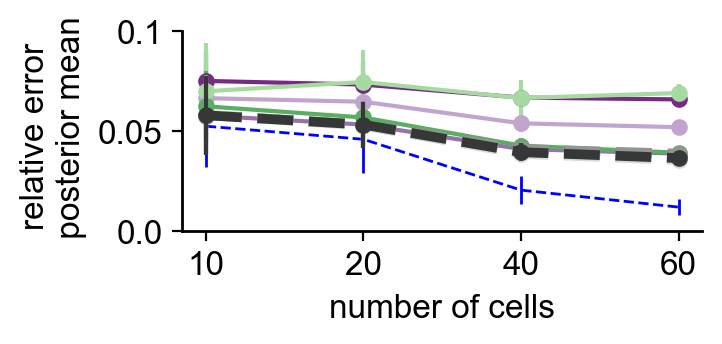

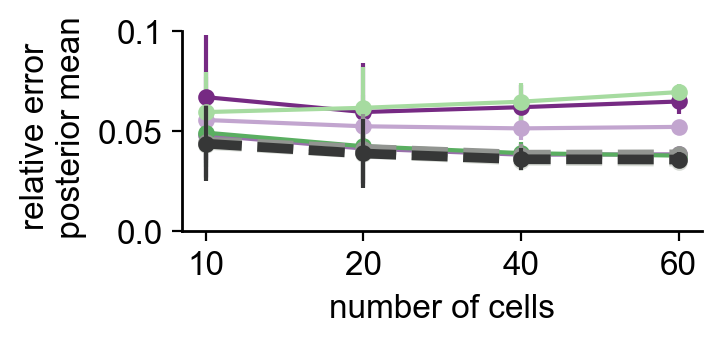

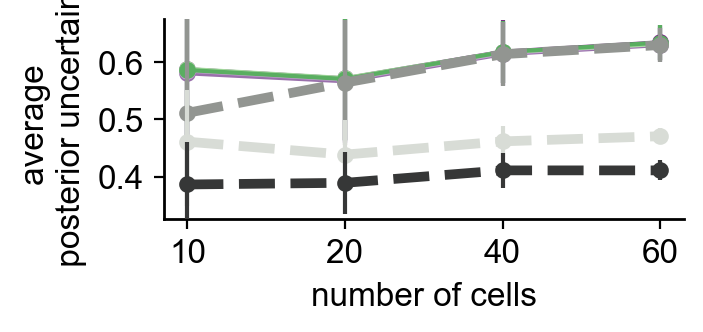

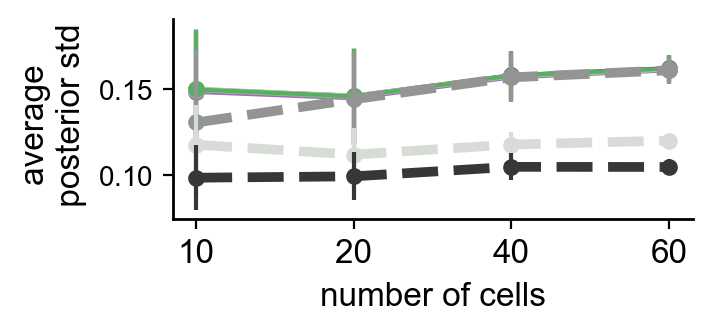

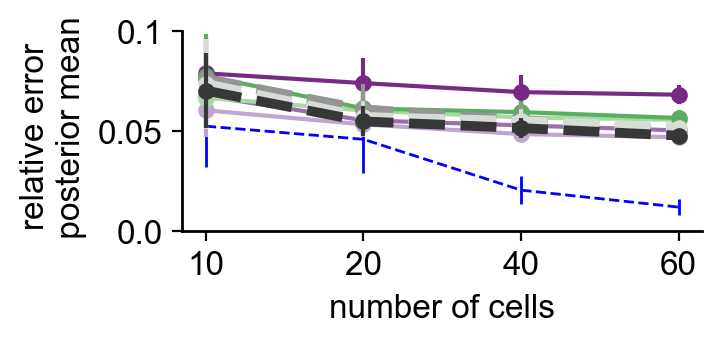

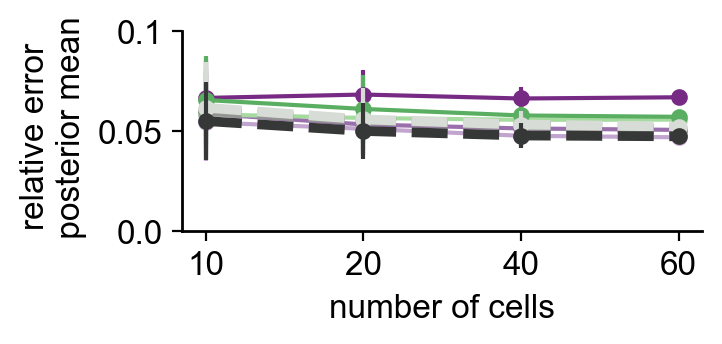

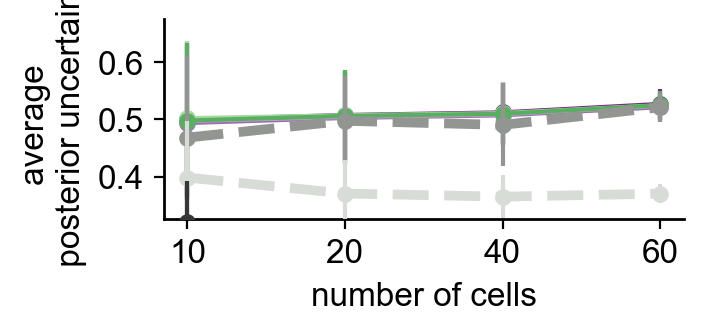

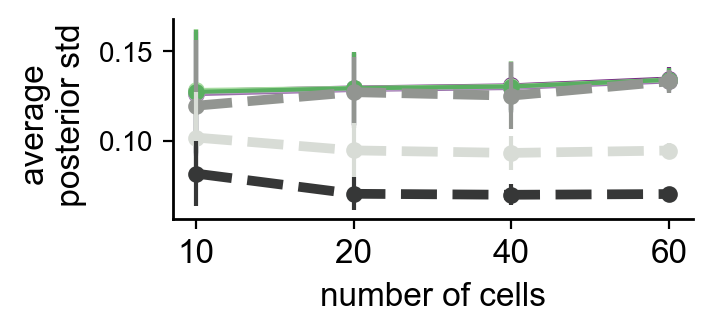

In [8]:
# colors = ['#762a83','#9970ab','#c2a5cf','#e7d4e8','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
colors = ['#762a83','#9970ab','#c2a5cf','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
print(subset_sizes)
for comp in ['CYTO', 'PM']:

    #####################
    ##### REL ERROR #####
    #####################
    fig, ax = get_sized_fig_ax(2.6, 1.0)
    rel_error_ful_dat_ = np.array([[rel_error_full_dat[comp][str(size)][model] for model in models+['pseudoBMA', 'stacking', 'BMA']] for size in subset_sizes])
    errs = np.nanmean(rel_error_ful_dat_, axis=2)
    errs_std = np.nanstd(rel_error_ful_dat_, axis=2)

    dat_rel_error = np.array([data_rel_error['CYTO'][str(size)] for size in subset_sizes])

    labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
    j = -3
    for i, col in enumerate(errs.T):
        ln = ax.errorbar(np.arange(len(subset_sizes)), col, yerr=errs_std.T[i], color=colors[i], linewidth=1.5, linestyle='-', marker='o', markersize=5.0, label=labels[i]) 
        if i>len(models)-1:
            ln[0].set_linestyle('--')
            ln[0].set_linewidth(3.5)
            ln[0].set_color(colors[j])
            ln[2][0].set_color(colors[j])
            j += 1
            if i==5:
                ln[0].set_zorder(10)
                ln[2][0].set_zorder(10)
            elif i==7:
                ln[0].set_zorder(9)
                ln[2][0].set_zorder(9)
            else:
                ln[0].set_zorder(8)
                ln[2][0].set_zorder(8)
                
    ax.set_xticks(np.arange(len(subset_sizes)), subset_sizes, fontsize=12.0)
    ax.set_ylabel('relative error \n posterior mean', fontsize=12.0)
    ax.set_xlabel('number of cells')
    ax.set_xticklabels(subset_sizes, fontsize=12.0)
    # ax.set_title('ERK activity: cytoplasm', fontsize=12.0)
    ax.set_ylim([0.0, 0.1])
    ax.set_yticks([0.0, 0.05, 0.1],[0.0, 0.05, 0.1], fontsize=12.0)

    ax.errorbar(np.arange(len(subset_sizes)), np.nanmean(dat_rel_error, axis=1), yerr=np.nanstd(dat_rel_error, axis=1), linestyle='--', linewidth=1.0, color='blue', zorder=-1, label='data')

    leg = ax.legend(loc='upper right', fontsize=8.0, bbox_to_anchor=(10.0, 1.0), ncol=4)
    export_legend(leg, filename=savedir + comp + '_rel_err_full_dat_legend.pdf')
    leg.remove()

    fig.savefig(savedir + comp + '_rel_err_full_dat.pdf', bbox_inches='tight', transparent=True)

    fig, ax = get_sized_fig_ax(2.6, 1.0)
    rel_error_sub_dat_ = np.array([[rel_error_sub_dat[comp][str(size)][model] for model in models+['pseudoBMA', 'stacking', 'BMA']] for size in subset_sizes])
    errs = np.nanmean(rel_error_sub_dat_, axis=2)
    errs_std = np.nanstd(rel_error_sub_dat_, axis=2)

    labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
    j = -3
    for i, col in enumerate(errs.T):
        ln = ax.errorbar(np.arange(len(subset_sizes)), col, yerr=errs_std.T[i], color=colors[i], linewidth=1.5, linestyle='-', marker='o', markersize=5.0, label=labels[i]) 
        if i>len(models)-1:
            ln[0].set_linestyle('--')
            ln[0].set_linewidth(3.5)
            ln[0].set_color(colors[j])
            ln[2][0].set_color(colors[j])
            j += 1
            if i==5:
                ln[0].set_zorder(10)
                ln[2][0].set_zorder(10)
            elif i==7:
                ln[0].set_zorder(9)
                ln[2][0].set_zorder(9)
            else:
                ln[0].set_zorder(8)
                ln[2][0].set_zorder(8)
                
    ax.set_xticks(np.arange(len(subset_sizes)), subset_sizes, fontsize=12.0)
    ax.set_ylabel('relative error \n posterior mean', fontsize=12.0)
    ax.set_xlabel('number of cells')
    ax.set_xticklabels(subset_sizes, fontsize=12.0)
    # ax.set_title('ERK activity: cytoplasm', fontsize=12.0)
    ax.set_ylim([0.0, 0.1])
    ax.set_yticks([0.0, 0.05, 0.1],[0.0, 0.05, 0.1], fontsize=12.0)

    fig.savefig(savedir + comp + '_rel_err_sub_dat.pdf', bbox_inches='tight', transparent=True)

    #####################
    ##### uncert95 ######
    #####################   
    fig, ax = get_sized_fig_ax(2.6, 1.0)
    uncert95_ = np.array([[uncert95[comp][str(size)][model] for model in models+['pseudoBMA', 'stacking', 'BMA']] for size in subset_sizes])
    errs = np.nanmean(uncert95_, axis=2)
    errs_std = np.nanstd(uncert95_, axis=2)

    labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
    j = -3
    for i, col in enumerate(errs.T):
        ln = ax.errorbar(np.arange(len(subset_sizes)), col, yerr=errs_std.T[i], color=colors[i], linewidth=1.5, linestyle='-', marker='o', markersize=5.0, label=labels[i]) 
        if i>len(models)-1:
            ln[0].set_linestyle('--')
            ln[0].set_linewidth(3.5)
            ln[0].set_color(colors[j])
            ln[2][0].set_color(colors[j])
            j += 1
            if i==5:
                ln[0].set_zorder(10)
                ln[2][0].set_zorder(10)
            elif i==7:
                ln[0].set_zorder(9)
                ln[2][0].set_zorder(9)
            else:
                ln[0].set_zorder(8)
                ln[2][0].set_zorder(8)
                
    ax.set_xticks(np.arange(len(subset_sizes)), subset_sizes, fontsize=12.0)
    ax.set_ylabel('average \n posterior uncertainty' , fontsize=12.0)
    ax.set_xlabel('number of cells')
    ax.set_xticklabels(subset_sizes, fontsize=12.0)

    ax.set_ylim([0.325, 0.675])
    ax.set_yticks([0.4, 0.5, 0.6],[0.4, 0.5, 0.6], fontsize=12.0)
    fig.savefig(savedir + comp + '_uncert95.pdf', bbox_inches='tight', transparent=True)

    fig, ax = get_sized_fig_ax(2.6, 1.0)
    std_ = np.array([[std[comp][str(size)][model] for model in models+['pseudoBMA', 'stacking', 'BMA']] for size in subset_sizes])
    errs = np.nanmean(std_, axis=2)
    errs_std = np.nanstd(std_, axis=2)

    labels = display_names + ['pseudo-BMA', 'stacking', 'BMA']
    j = -3
    for i, col in enumerate(errs.T):
        ln = ax.errorbar(np.arange(len(subset_sizes)), col, yerr=errs_std.T[i], color=colors[i], linewidth=1.5, linestyle='-', marker='o', markersize=5.0, label=labels[i]) 
        if i>len(models)-1:
            ln[0].set_linestyle('--')
            ln[0].set_linewidth(3.5)
            ln[0].set_color(colors[j])
            ln[2][0].set_color(colors[j])
            j += 1
            if i==5:
                ln[0].set_zorder(10)
                ln[2][0].set_zorder(10)
            elif i==6:
                ln[0].set_zorder(8)
                ln[2][0].set_zorder(8)
            elif i==7:
                ln[0].set_zorder(9)
                ln[2][0].set_zorder(9)
            else:
                ln[0].set_zorder(7)
                ln[2][0].set_zorder(7)
                
    ax.set_xticks(np.arange(len(subset_sizes)), subset_sizes, fontsize=12.0)
    ax.set_ylabel('average \n posterior std' , fontsize=12.0)
    ax.set_xlabel('number of cells')
    ax.set_xticklabels(subset_sizes, fontsize=12.0)
    
    fig.savefig(savedir + comp + '_std.pdf', bbox_inches='tight', transparent=True)